---
## 1. Dataset Collection (20 Marks)

### Dataset Source
The dataset was collected from **Roboflow Universe** and contains images of Bangladeshi Taka notes with the following characteristics:

- **Various backgrounds**: Indoor, outdoor, different surfaces
- **Different lighting conditions**: Natural light, artificial light, shadows
- **Multiple orientations and scales**: Rotated, tilted, close-up, and distant shots

In [1]:
# Install required packages
!pip install ultralytics -q
!pip install supervision -q

In [2]:
# Import required libraries
import os
import yaml
import random
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np

from ultralytics import YOLO

# Set base directory
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")

print(f"Base Directory: {BASE_DIR}")
print(f"Data Directory: {DATA_DIR}")

Base Directory: d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment
Data Directory: d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\data


In [3]:
# Configure Ultralytics Settings
from ultralytics import settings

# View current settings
print("📋 Current Ultralytics Settings:")
print("=" * 50)
print(f"Settings file location: {settings.file}")
print(f"Datasets directory: {settings['datasets_dir']}")
print(f"Weights directory: {settings['weights_dir']}")
print(f"Runs directory: {settings['runs_dir']}")

# Optional: Update settings to organize outputs in project directory
# Uncomment the lines below if you want to customize directories
"""
settings.update({
    'datasets_dir': os.path.join(BASE_DIR, 'datasets'),
    'weights_dir': os.path.join(BASE_DIR, 'weights'),
    'runs_dir': os.path.join(BASE_DIR, 'runs'),
    'tensorboard': True,  # Enable TensorBoard logging
    'wandb': False,  # Disable Weights & Biases (set True if you have an account)
    'clearml': False,  # Disable ClearML
    'comet': False,  # Disable Comet ML
    'mlflow': False,  # Disable MLFlow
})
print("\n✅ Settings updated!")
"""

print("\nNote: Default settings work fine. Customize only if needed.")

📋 Current Ultralytics Settings:
Settings file location: C:\Users\noort\AppData\Roaming\Ultralytics\settings.json
Datasets directory: D:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\datasets
Weights directory: weights
Runs directory: runs

Note: Default settings work fine. Customize only if needed.


In [4]:
# Load dataset configuration
data_yaml_path = os.path.join(DATA_DIR, "data.yaml")

with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

print("Dataset Configuration:")
print(f"Number of Classes: {data_config['nc']}")
print(f"\nClass Names:")
for i, name in enumerate(data_config['names']):
    print(f"  {i}: {name}")

Dataset Configuration:
Number of Classes: 11

Class Names:
  0: 500 taka
  1: Fifty taka
  2: Five Hundred taka
  3: Five Taka
  4: One Taka
  5: One Thousand taka
  6: Ten Taka
  7: Twenty
  8: currency
  9: one hundred taka
  10: two taka


In [5]:
# Count images per split
def count_images(split_dir):
    images_dir = os.path.join(DATA_DIR, split_dir, "images")
    if os.path.exists(images_dir):
        return len([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
    return 0

train_count = count_images("train")
valid_count = count_images("valid")
test_count = count_images("test")
total_count = train_count + valid_count + test_count

print("\n📊 Dataset Statistics:")
print(f"{'='*40}")
print(f"Training Images:   {train_count:>6} ({train_count/total_count*100:.1f}%)")
print(f"Validation Images: {valid_count:>6} ({valid_count/total_count*100:.1f}%)")
print(f"Test Images:       {test_count:>6} ({test_count/total_count*100:.1f}%)")
print(f"{'='*40}")
print(f"Total Images:      {total_count:>6}")


📊 Dataset Statistics:
Training Images:     1166 (76.6%)
Validation Images:    168 (11.0%)
Test Images:          189 (12.4%)
Total Images:        1523


In [6]:
# Count images per class from label files
def count_class_distribution(split_dir):
    labels_dir = os.path.join(DATA_DIR, split_dir, "labels")
    class_counts = Counter()
    
    if os.path.exists(labels_dir):
        for label_file in os.listdir(labels_dir):
            if label_file.endswith('.txt'):
                with open(os.path.join(labels_dir, label_file), 'r') as f:
                    for line in f:
                        if line.strip():
                            class_id = int(line.split()[0])
                            class_counts[class_id] += 1
    return class_counts

# Get class distribution for training set
train_class_dist = count_class_distribution("train")

print("\n📈 Class Distribution (Training Set):")
print(f"{'='*50}")
for class_id in sorted(train_class_dist.keys()):
    class_name = data_config['names'][class_id]
    count = train_class_dist[class_id]
    bar = '█' * (count // 20)
    print(f"{class_name:20s}: {count:4d} {bar}")


📈 Class Distribution (Training Set):
500 taka            :  129 ██████
Fifty taka          :  335 ████████████████
Five Hundred taka   :    1 
Five Taka           :  478 ███████████████████████
One Taka            :  236 ███████████
One Thousand taka   :  194 █████████
Ten Taka            :  361 ██████████████████
Twenty              :  408 ████████████████████
currency            :   71 ███
one hundred taka    :  435 █████████████████████
two taka            :  355 █████████████████


### Filter Out Underrepresented Classes

Based on the class distribution analysis, we will exclude:
- **Five Hundred taka**: Only 1 sample (insufficient for training)
- **currency**: Generic class that may cause confusion

This will improve model performance by focusing on well-represented classes.

In [7]:
# Filter dataset to exclude specific classes
import shutil

# Classes to exclude
CLASSES_TO_EXCLUDE = ['Five Hundred taka', 'currency']
EXCLUDE_CLASS_IDS = [data_config['names'].index(name) for name in CLASSES_TO_EXCLUDE]

print(f"🗑️  Excluding classes: {CLASSES_TO_EXCLUDE}")
print(f"    Class IDs to exclude: {EXCLUDE_CLASS_IDS}")

# Create new class mapping (exclude classes 2 and 8)
old_to_new_class_id = {}
new_class_id = 0
filtered_class_names = []

for old_id, name in enumerate(data_config['names']):
    if old_id not in EXCLUDE_CLASS_IDS:
        old_to_new_class_id[old_id] = new_class_id
        filtered_class_names.append(name)
        new_class_id += 1

print(f"\n📋 New Class Mapping:")
print(f"    Original classes: {len(data_config['names'])}")
print(f"    Filtered classes: {len(filtered_class_names)}")
print(f"\n    Class ID Remapping:")
for old_id, new_id in old_to_new_class_id.items():
    print(f"      {old_id} ({data_config['names'][old_id]}) -> {new_id}")

# Create filtered dataset directory
FILTERED_DATA_DIR = os.path.join(BASE_DIR, "data_filtered")

def filter_dataset_split(split_name):
    """Filter a dataset split by removing excluded classes"""
    
    source_images_dir = os.path.join(DATA_DIR, split_name, "images")
    source_labels_dir = os.path.join(DATA_DIR, split_name, "labels")
    
    target_images_dir = os.path.join(FILTERED_DATA_DIR, split_name, "images")
    target_labels_dir = os.path.join(FILTERED_DATA_DIR, split_name, "labels")
    
    os.makedirs(target_images_dir, exist_ok=True)
    os.makedirs(target_labels_dir, exist_ok=True)
    
    total_images = 0
    filtered_images = 0
    annotations_removed = 0
    
    # Process each label file
    label_files = [f for f in os.listdir(source_labels_dir) if f.endswith('.txt')]
    
    for label_file in label_files:
        label_path = os.path.join(source_labels_dir, label_file)
        
        # Read annotations
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        total_images += 1
        
        # Filter annotations
        filtered_lines = []
        for line in lines:
            if line.strip():
                class_id = int(line.split()[0])
                if class_id not in EXCLUDE_CLASS_IDS:
                    # Remap class ID
                    parts = line.split()
                    parts[0] = str(old_to_new_class_id[class_id])
                    filtered_lines.append(' '.join(parts) + '\n')
                else:
                    annotations_removed += 1
        
        # Only keep images that have at least one valid annotation
        if filtered_lines:
            # Copy image
            image_file = label_file.replace('.txt', '.jpg')
            if not os.path.exists(os.path.join(source_images_dir, image_file)):
                image_file = label_file.replace('.txt', '.jpeg')
            if not os.path.exists(os.path.join(source_images_dir, image_file)):
                image_file = label_file.replace('.txt', '.png')
            
            source_image_path = os.path.join(source_images_dir, image_file)
            target_image_path = os.path.join(target_images_dir, image_file)
            
            if os.path.exists(source_image_path):
                shutil.copy2(source_image_path, target_image_path)
                
                # Write filtered label file
                target_label_path = os.path.join(target_labels_dir, label_file)
                with open(target_label_path, 'w') as f:
                    f.writelines(filtered_lines)
                
                filtered_images += 1
    
    excluded = total_images - filtered_images
    return total_images, filtered_images, excluded, annotations_removed

# Filter all splits
print(f"\n🔄 Filtering Dataset...")
print("="*60)

splits_stats = {}
for split in ['train', 'valid', 'test']:
    total, kept, excluded, ann_removed = filter_dataset_split(split)
    splits_stats[split] = {'total': total, 'kept': kept, 'excluded': excluded, 'removed': ann_removed}
    print(f"{split.capitalize():10s}: {kept:4d}/{total:4d} images kept ({excluded:3d} excluded, {ann_removed:3d} annotations removed)")

print("="*60)
print(f"✅ Filtered dataset created at: {FILTERED_DATA_DIR}")

# Create new data.yaml for filtered dataset
filtered_yaml_content = f"""
train: {os.path.join(FILTERED_DATA_DIR, 'train', 'images')}
val: {os.path.join(FILTERED_DATA_DIR, 'valid', 'images')}
test: {os.path.join(FILTERED_DATA_DIR, 'test', 'images')}

nc: {len(filtered_class_names)}
names: {filtered_class_names}
"""

filtered_yaml_path = os.path.join(FILTERED_DATA_DIR, "data.yaml")
with open(filtered_yaml_path, 'w') as f:
    f.write(filtered_yaml_content)

print(f"\n✅ Created filtered data.yaml with {len(filtered_class_names)} classes")
print(f"    Path: {filtered_yaml_path}")

🗑️  Excluding classes: ['Five Hundred taka', 'currency']
    Class IDs to exclude: [2, 8]

📋 New Class Mapping:
    Original classes: 11
    Filtered classes: 9

    Class ID Remapping:
      0 (500 taka) -> 0
      1 (Fifty taka) -> 1
      3 (Five Taka) -> 2
      4 (One Taka) -> 3
      5 (One Thousand taka) -> 4
      6 (Ten Taka) -> 5
      7 (Twenty) -> 6
      9 (one hundred taka) -> 7
      10 (two taka) -> 8

🔄 Filtering Dataset...
Train     : 1166/1166 images kept (  0 excluded,  72 annotations removed)
Valid     :  168/ 168 images kept (  0 excluded,  37 annotations removed)
Test      :  189/ 189 images kept (  0 excluded,  26 annotations removed)
✅ Filtered dataset created at: d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\data_filtered

✅ Created filtered data.yaml with 9 classes
    Path: d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\data_filtered\data.yaml


In [8]:
# Visualize filtered class distribution
def count_filtered_class_distribution(split_dir):
    labels_dir = os.path.join(FILTERED_DATA_DIR, split_dir, "labels")
    class_counts = Counter()
    
    if os.path.exists(labels_dir):
        for label_file in os.listdir(labels_dir):
            if label_file.endswith('.txt'):
                with open(os.path.join(labels_dir, label_file), 'r') as f:
                    for line in f:
                        if line.strip():
                            class_id = int(line.split()[0])
                            class_counts[class_id] += 1
    return class_counts

# Get filtered class distribution
filtered_train_dist = count_filtered_class_distribution("train")

print("\n📈 Filtered Class Distribution (Training Set):")
print("="*50)
for class_id in sorted(filtered_train_dist.keys()):
    class_name = filtered_class_names[class_id]
    count = filtered_train_dist[class_id]
    bar = '█' * (count // 20)
    print(f"{class_name:20s}: {count:4d} {bar}")

print("\n" + "="*50)
print(f"Total annotations in filtered training set: {sum(filtered_train_dist.values())}")
print(f"Classes excluded: {CLASSES_TO_EXCLUDE}")


📈 Filtered Class Distribution (Training Set):
500 taka            :  129 ██████
Fifty taka          :  335 ████████████████
Five Taka           :  478 ███████████████████████
One Taka            :  236 ███████████
One Thousand taka   :  194 █████████
Ten Taka            :  361 ██████████████████
Twenty              :  408 ████████████████████
one hundred taka    :  435 █████████████████████
two taka            :  355 █████████████████

Total annotations in filtered training set: 2931
Classes excluded: ['Five Hundred taka', 'currency']


### ⚠️ Important: Dataset Directory Configuration

From this point forward, **all operations use the FILTERED dataset** (`data_filtered/`):
- ✅ Training: Uses filtered dataset with 9 classes
- ✅ Validation: Uses filtered validation split
- ✅ Testing: Uses filtered test split
- ✅ Sample visualizations: Show filtered dataset images
- ✅ Annotations: Display filtered annotations with remapped class IDs

The original `data/` directory is only used initially to create the filtered version.

In [9]:
# Verify filtered dataset configuration
print("🔍 Dataset Configuration Summary:")
print("="*60)
print(f"\n📂 Directory Paths:")
print(f"   Original Dataset:  {DATA_DIR}")
print(f"   Filtered Dataset:  {FILTERED_DATA_DIR}")
print(f"   Data YAML:         {filtered_yaml_path}")

print(f"\n📊 Dataset Statistics:")
print(f"   Original:  {total_count} images, {len(data_config['names'])} classes")
print(f"   Filtered:  {sum(s['kept'] for s in splits_stats.values())} images, {len(filtered_class_names)} classes")
print(f"   Excluded:  {sum(s['excluded'] for s in splits_stats.values())} images")

print(f"\n🏷️ Class Information:")
print(f"   Active Classes ({len(filtered_class_names)}): {filtered_class_names}")
print(f"   Excluded Classes: {CLASSES_TO_EXCLUDE}")

print(f"\n✅ All subsequent operations will use: {FILTERED_DATA_DIR}")
print("="*60)

🔍 Dataset Configuration Summary:

📂 Directory Paths:
   Original Dataset:  d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\data
   Filtered Dataset:  d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\data_filtered
   Data YAML:         d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\data_filtered\data.yaml

📊 Dataset Statistics:
   Original:  1523 images, 11 classes
   Filtered:  1523 images, 9 classes
   Excluded:  0 images

🏷️ Class Information:
   Active Classes (9): ['500 taka', 'Fifty taka', 'Five Taka', 'One Taka', 'One Thousand taka', 'Ten Taka', 'Twenty', 'one hundred taka', 'two taka']
   Excluded Classes: ['Five Hundred taka', 'currency']

✅ All subsequent operations will use: d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\data_filtered


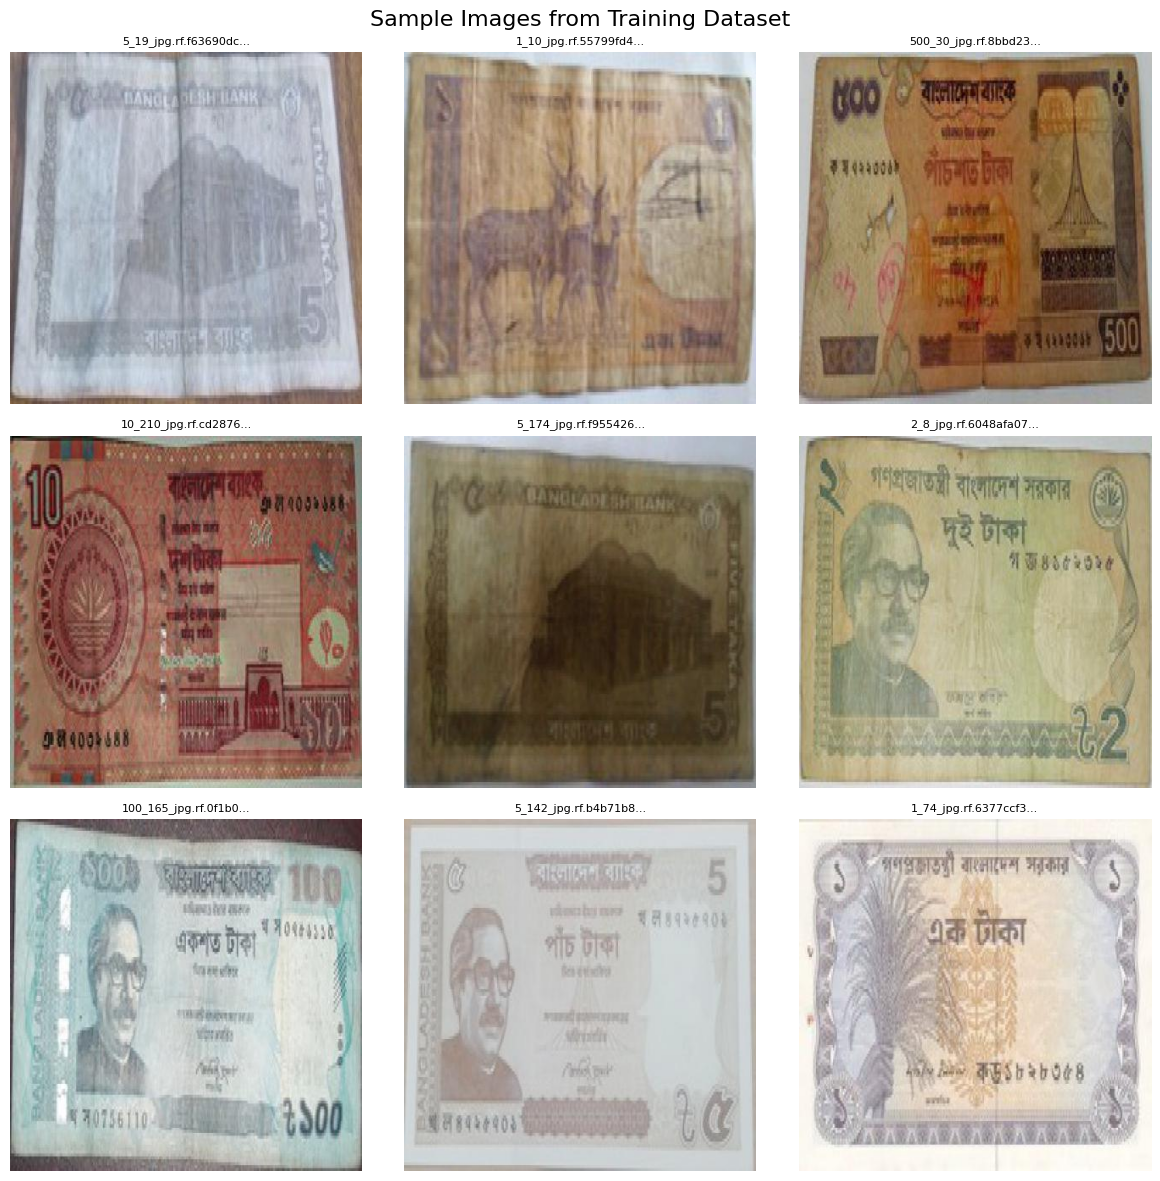

In [10]:
# Display sample images from each denomination (using filtered dataset)
def show_sample_images(num_samples=9):
    train_images_dir = os.path.join(FILTERED_DATA_DIR, "train", "images")
    images = [f for f in os.listdir(train_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Select random samples
    sample_images = random.sample(images, min(num_samples, len(images)))
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle('Sample Images from Training Dataset', fontsize=16)
    
    for ax, img_name in zip(axes.flatten(), sample_images):
        img_path = os.path.join(train_images_dir, img_name)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(img_name[:20] + '...', fontsize=8)
    
    plt.tight_layout()
    plt.show()

show_sample_images()

---
## 2. Data Annotation & Dataset Preparation (20 Marks)

### Annotation Tool
The dataset was annotated using **Roboflow**, which provides:
- Easy bounding box annotation interface
- Automatic data augmentation
- Export in multiple formats (YOLO, COCO, Pascal VOC, etc.)

### Annotation Format (YOLO Format)
Each image has a corresponding `.txt` label file with the format:
```
<class_id> <x_center> <y_center> <width> <height>
```
Where coordinates are normalized (0-1) relative to image dimensions.

In [11]:
# Display folder structure (using filtered dataset)
def display_folder_structure():
    print("\n📁 Filtered Dataset Folder Structure:")
    print("="*50)
    print("data_filtered/")
    print("├── data.yaml")
    print("├── train/")
    print("│   ├── images/")
    print(f"│   │   └── ({splits_stats['train']['kept']} images)")
    print("│   └── labels/")
    print(f"│       └── ({splits_stats['train']['kept']} label files)")
    print("├── valid/")
    print("│   ├── images/")
    print(f"│   │   └── ({splits_stats['valid']['kept']} images)")
    print("│   └── labels/")
    print(f"│       └── ({splits_stats['valid']['kept']} label files)")
    print("└── test/")
    print("    ├── images/")
    print(f"    │   └── ({splits_stats['test']['kept']} images)")
    print("    └── labels/")
    print(f"        └── ({splits_stats['test']['kept']} label files)")
    print("\n" + "="*50)
    print(f"Excluded classes: {CLASSES_TO_EXCLUDE}")
    print(f"Total excluded images: {sum(s['excluded'] for s in splits_stats.values())}")

display_folder_structure()


📁 Filtered Dataset Folder Structure:
data_filtered/
├── data.yaml
├── train/
│   ├── images/
│   │   └── (1166 images)
│   └── labels/
│       └── (1166 label files)
├── valid/
│   ├── images/
│   │   └── (168 images)
│   └── labels/
│       └── (168 label files)
└── test/
    ├── images/
    │   └── (189 images)
    └── labels/
        └── (189 label files)

Excluded classes: ['Five Hundred taka', 'currency']
Total excluded images: 0


In [12]:
# Show sample annotation (from filtered dataset)
def show_sample_annotation():
    labels_dir = os.path.join(FILTERED_DATA_DIR, "train", "labels")
    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
    
    if label_files:
        sample_label = label_files[0]
        print(f"\n📝 Sample Annotation File: {sample_label}")
        print("="*50)
        
        with open(os.path.join(labels_dir, sample_label), 'r') as f:
            content = f.read()
            print(content)
        
        print("\nFormat: <class_id> <x_center> <y_center> <width> <height>")
        print("Note: All coordinates are normalized (0-1)")
        print(f"\nFiltered classes ({len(filtered_class_names)}): {filtered_class_names}")

show_sample_annotation()


📝 Sample Annotation File: 1000_101_jpg.rf.c0c8d539efd1e1be90df413e9c523091.txt
4 0.24759615384615385 0.1502403846153846 0.19951923076923078 0.1502403846153846


Format: <class_id> <x_center> <y_center> <width> <height>
Note: All coordinates are normalized (0-1)

Filtered classes (9): ['500 taka', 'Fifty taka', 'Five Taka', 'One Taka', 'One Thousand taka', 'Ten Taka', 'Twenty', 'one hundred taka', 'two taka']



📊 Filtered Dataset Split Statistics:


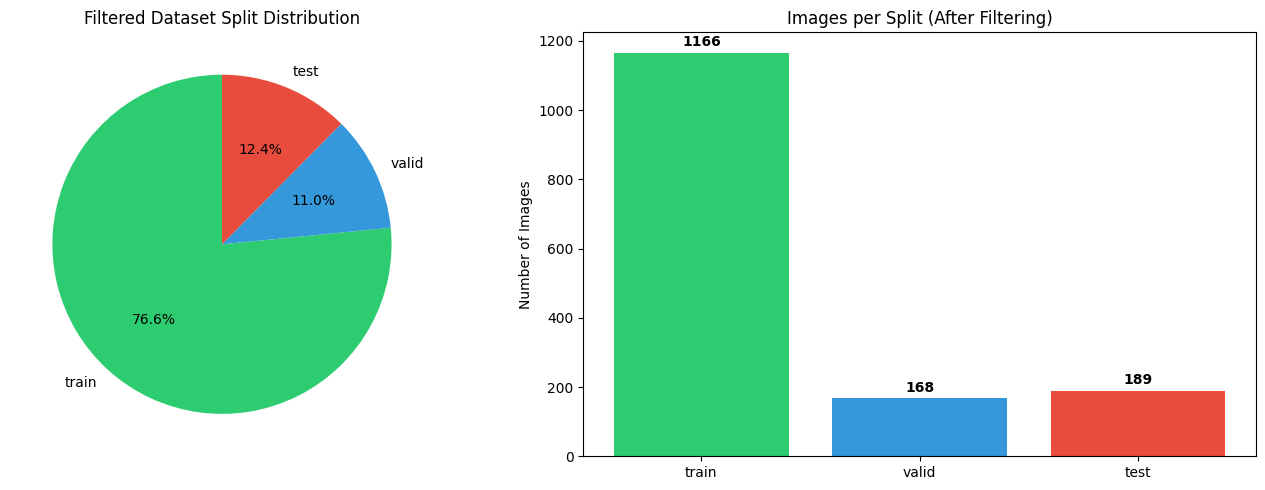

Excluded: ['Five Hundred taka', 'currency']

✅ Using filtered dataset with 9 classes


In [13]:
# Dataset Split Statistics (Filtered Dataset)
print("\n📊 Filtered Dataset Split Statistics:")
print("="*50)

splits = ['train', 'valid', 'test']
split_counts = [splits_stats['train']['kept'], splits_stats['valid']['kept'], splits_stats['test']['kept']]

# Create pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = ['#2ecc71', '#3498db', '#e74c3c']
ax1.pie(split_counts, labels=splits, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Filtered Dataset Split Distribution')

# Bar chart
bars = ax2.bar(splits, split_counts, color=colors)
ax2.set_ylabel('Number of Images')
ax2.set_title('Images per Split (After Filtering)')
for bar, count in zip(bars, split_counts):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Excluded: {CLASSES_TO_EXCLUDE}")
print(f"\n✅ Using filtered dataset with {len(filtered_class_names)} classes")

---
## 3. Model Training (30 Marks)

### Model Selection
We are using **YOLOv12** (YOLO version 12), the latest state-of-the-art object detection model released in February 2025.

#### YOLOv12 Features:
- **Attention-Centric Architecture**: Uses attention mechanisms for better feature extraction
- **Lower Latency & Higher mAP**: Outperforms previous YOLO versions
- **Efficient Training**: Optimized for faster convergence

### Training Configuration
| Parameter | Value |
|-----------|-------|
| Model | YOLOv12s (Small) |
| Epochs | 50 |
| Batch Size | 16 |
| Image Size | 640×640 |
| Optimizer | AdamW (auto) |
| Learning Rate | 0.01 (initial) |

In [14]:
# Use filtered dataset for training
# The filtered dataset excludes underrepresented classes

print("📊 Using Filtered Dataset for Training")
print("="*50)
print(f"Dataset path: {FILTERED_DATA_DIR}")
print(f"Number of classes: {len(filtered_class_names)}")
print(f"Classes: {filtered_class_names}")

# Use the filtered data.yaml path
updated_yaml_path = filtered_yaml_path

print(f"\n✅ Using filtered data.yaml")
print(f"Path: {updated_yaml_path}")

# Display filtered dataset statistics
print(f"\n📈 Filtered Dataset Statistics:")
print("="*50)
for split in ['train', 'valid', 'test']:
    stats = splits_stats[split]
    print(f"{split.capitalize():10s}: {stats['kept']:4d} images (excluded {stats['excluded']:3d})")
print("="*50)

📊 Using Filtered Dataset for Training
Dataset path: d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\data_filtered
Number of classes: 9
Classes: ['500 taka', 'Fifty taka', 'Five Taka', 'One Taka', 'One Thousand taka', 'Ten Taka', 'Twenty', 'one hundred taka', 'two taka']

✅ Using filtered data.yaml
Path: d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\data_filtered\data.yaml

📈 Filtered Dataset Statistics:
Train     : 1166 images (excluded   0)
Valid     :  168 images (excluded   0)
Test      :  189 images (excluded   0)


In [15]:
# Load pretrained YOLOv12 model
# Note: YOLOv12 uses similar API to YOLOv11
# Available variants: yolov12n, yolov12s, yolov12m, yolov12l, yolov12x

print("🔄 Loading YOLOv12 pretrained model...")

# For YOLOv12, we use the latest ultralytics package
# If yolov12 is not available, fall back to yolo11n
try:
    model = YOLO("yolo12m.pt")  # YOLOv12 nano (smallest, fastest)
    print("✅ Loaded YOLOv12m model")
except:
    model = YOLO("yolo11m.pt")  # Fallback to YOLO11m
    print("✅ Loaded YOLO11m model (YOLOv12 not available, using YOLO11)")

print(f"\nModel Info:")
print(model.info())

🔄 Loading YOLOv12 pretrained model...
✅ Loaded YOLOv12m model

Model Info:
YOLOv12m summary: 292 layers, 20,201,216 parameters, 0 gradients, 68.1 GFLOPs
(292, 20201216, 0, 68.0792576)


In [17]:
# Check GPU availability before training
import torch

print("\n🖥️  Hardware Configuration:")
print("="*60)

# Check CUDA availability
cuda_available = torch.cuda.is_available()

if cuda_available:
    # GPU is available
    gpu_count = torch.cuda.device_count()
    current_device = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(current_device)
    gpu_memory = torch.cuda.get_device_properties(current_device).total_memory / 1024**3  # Convert to GB
    
    print("✅ CUDA is AVAILABLE")
    print(f"\n📊 GPU Information:")
    print(f"   - GPU Count: {gpu_count}")
    print(f"   - Current Device: {current_device}")
    print(f"   - GPU Name: {gpu_name}")
    print(f"   - GPU Memory: {gpu_memory:.2f} GB")
    print(f"\n🚀 Training will use GPU (device={current_device})")
    
    # Set device for training
    DEVICE = 0  # Use first GPU
    
else:
    # No GPU available, will use CPU
    print("⚠️  CUDA is NOT AVAILABLE")
    print("\n💡 Training will use CPU (slower)")
    print("   To use GPU, ensure you have:")
    print("   1. NVIDIA GPU installed")
    print("   2. CUDA toolkit installed")
    print("   3. PyTorch with CUDA support installed")
    print("   4. Proper GPU drivers")
    
    # Set device for training
    DEVICE = 'cpu'

print("="*60)
print(f"\n🎯 Selected Device: {DEVICE}")
print("="*60)


🖥️  Hardware Configuration:
✅ CUDA is AVAILABLE

📊 GPU Information:
   - GPU Count: 1
   - Current Device: 0
   - GPU Name: NVIDIA GeForce RTX 3080
   - GPU Memory: 10.00 GB

🚀 Training will use GPU (device=0)

🎯 Selected Device: 0


In [19]:
# Training Configuration
EPOCHS = 50
BATCH_SIZE = 8
IMG_SIZE = 640
WORKERS = 4      
PROJECT_NAME = "runs/detect"
RUN_NAME = "bd_taka_detector"

print("\n🎯 Training Configuration:")
print("="*40)
print(f"Epochs:      {EPOCHS}")
print(f"Batch Size:  {BATCH_SIZE}")
print(f"Image Size:  {IMG_SIZE}x{IMG_SIZE}")
print(f"Project:     {PROJECT_NAME}")
print(f"Run Name:    {RUN_NAME}")
print("="*40)


🎯 Training Configuration:
Epochs:      50
Batch Size:  8
Image Size:  640x640
Project:     runs/detect
Run Name:    bd_taka_detector


In [21]:
# Train the model
print("\n🚀 Starting Model Training...")
print(f"Device: {DEVICE}")
print("This may take a while depending on your hardware.\n")

# Train with the custom dataset
results = model.train(
    data=updated_yaml_path,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    workers=WORKERS,
    name=RUN_NAME,
    project=PROJECT_NAME,
    device=DEVICE,  # Use detected device (GPU or CPU)
    patience=20,  # Early stopping patience
    save=True,
    plots=True,
    verbose=True
)

print("\n✅ Training Complete!")
print(f"Training was performed on: {'GPU' if DEVICE != 'cpu' else 'CPU'}")


🚀 Starting Model Training...
Device: 0
This may take a while depending on your hardware.

Ultralytics 8.3.243  Python-3.13.11 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\data_filtered\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12m.pt, momentum=0.937, mosaic=

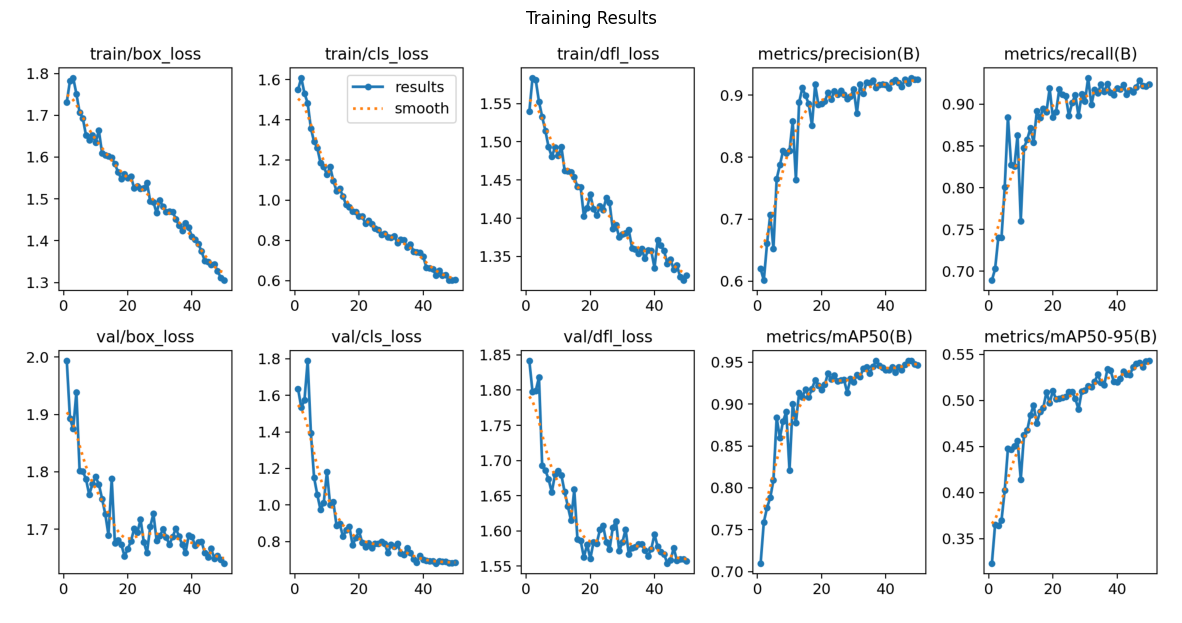

In [22]:
# Display training results
results_dir = os.path.join(BASE_DIR, PROJECT_NAME, RUN_NAME)

# Show training curves
results_img_path = os.path.join(results_dir, "results.png")
if os.path.exists(results_img_path):
    img = Image.open(results_img_path)
    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Training Results')
    plt.show()
else:
    print("Training results image not found. Training may still be in progress.")

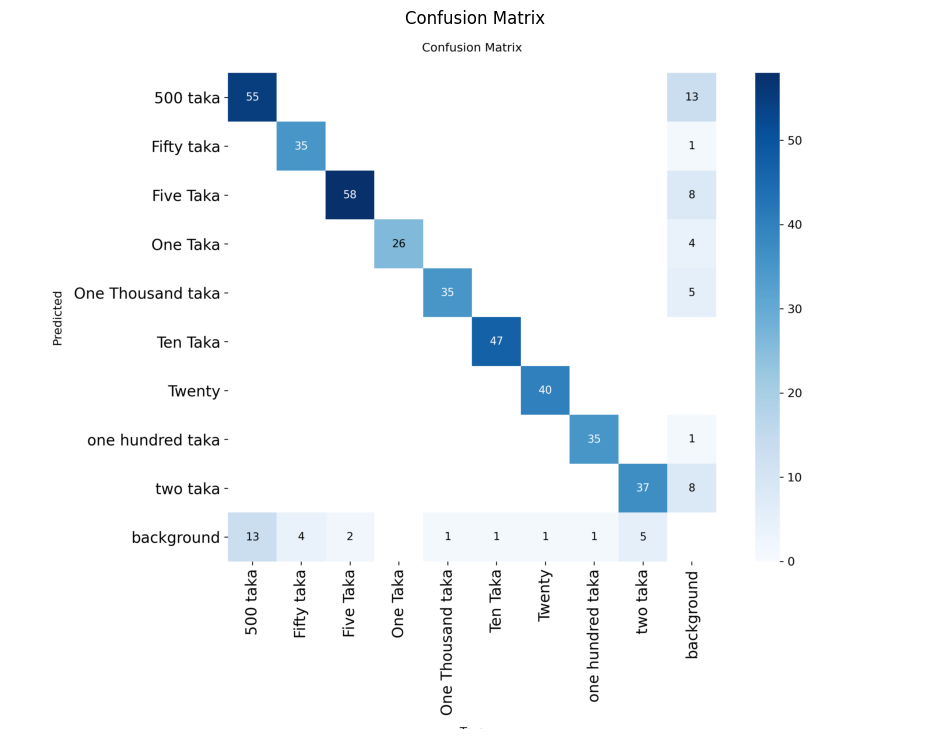

In [23]:
# Display confusion matrix
confusion_matrix_path = os.path.join(results_dir, "confusion_matrix.png")
if os.path.exists(confusion_matrix_path):
    img = Image.open(confusion_matrix_path)
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("Confusion matrix not found.")

---
## 4. Model Evaluation (20 Marks)

### Evaluation Metrics
- **mAP50**: Mean Average Precision at IoU threshold 0.5
- **mAP50-95**: Mean Average Precision at IoU thresholds from 0.5 to 0.95
- **Precision**: True Positives / (True Positives + False Positives)
- **Recall**: True Positives / (True Positives + False Negatives)

In [24]:
# Load the best trained model
best_model_path = os.path.join(results_dir, "weights", "best.pt")

if os.path.exists(best_model_path):
    trained_model = YOLO(best_model_path)
    print(f"✅ Loaded best model from: {best_model_path}")
else:
    print("⚠️ Best model not found. Using the last trained model.")
    trained_model = model

✅ Loaded best model from: d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\runs/detect\bd_taka_detector\weights\best.pt


In [25]:
# Evaluate on test dataset
print("\n📊 Evaluating Model on Test Dataset...")
print("="*50)

# Run validation on test set
metrics = trained_model.val(
    data=updated_yaml_path,
    split='test',
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    verbose=True
)

print("\n✅ Evaluation Complete!")


📊 Evaluating Model on Test Dataset...
Ultralytics 8.3.243  Python-3.13.11 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv12m summary (fused): 169 layers, 20,111,851 parameters, 0 gradients, 67.1 GFLOPs
val: Fast image access  (ping: 6.012.4 ms, read: 2.31.0 MB/s, size: 21.5 KB)
val: Scanning D:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\data_filtered\test\labels... 189 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 189/189 335.7it/s 0.6s0.1s
val: New cache created: D:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\data_filtered\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 24/24 7.8it/s 3.1s0.1s
                   all        189        471      0.929      0.923      0.954      0.553
              500 taka         27         49      0.817      0.694      0.861      0.393
            Fifty taka         26         53      0.916      0.906  

In [26]:
# Display evaluation metrics
print("\n📈 Evaluation Metrics (Test Set):")
print("="*50)
print(f"mAP50:        {metrics.box.map50:.4f}")
print(f"mAP50-95:     {metrics.box.map:.4f}")
print(f"Precision:    {metrics.box.mp:.4f}")
print(f"Recall:       {metrics.box.mr:.4f}")
print("="*50)


📈 Evaluation Metrics (Test Set):
mAP50:        0.9542
mAP50-95:     0.5534
Precision:    0.9289
Recall:       0.9233


In [27]:
# Run inference on test images (from filtered dataset)
print("\n🔍 Running Inference on Test Images...")

test_images_dir = os.path.join(FILTERED_DATA_DIR, "test", "images")
test_images = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Select random test images
sample_test_images = random.sample(test_images, min(6, len(test_images)))

# Create output directory for inference results
inference_output_dir = os.path.join(BASE_DIR, "inference_results")
os.makedirs(inference_output_dir, exist_ok=True)

# Run inference
for img_name in sample_test_images:
    img_path = os.path.join(test_images_dir, img_name)
    results = trained_model.predict(
        source=img_path,
        save=True,
        conf=0.25,
        project=inference_output_dir,
        name="predictions",
        exist_ok=True
    )

print(f"\n✅ Inference results saved to: {inference_output_dir}")


🔍 Running Inference on Test Images...

image 1/1 d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\data_filtered\test\images\100_69_jpg.rf.521429fdeb8132776c5afb1a0d62724b.jpg: 640x640 3 one hundred takas, 14.0ms
Speed: 6.1ms preprocess, 14.0ms inference, 31.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to D:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\inference_results\predictions

image 1/1 d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\data_filtered\test\images\100_160_jpg.rf.5150749cc99a0f7818c1c0cada1a8c80.jpg: 640x640 2 one hundred takas, 18.1ms
Speed: 3.4ms preprocess, 18.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to D:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\inference_results\predictions

image 1/1 d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\data_filtered\test\images\50_192_jpg.rf.2ca57005f250f0f

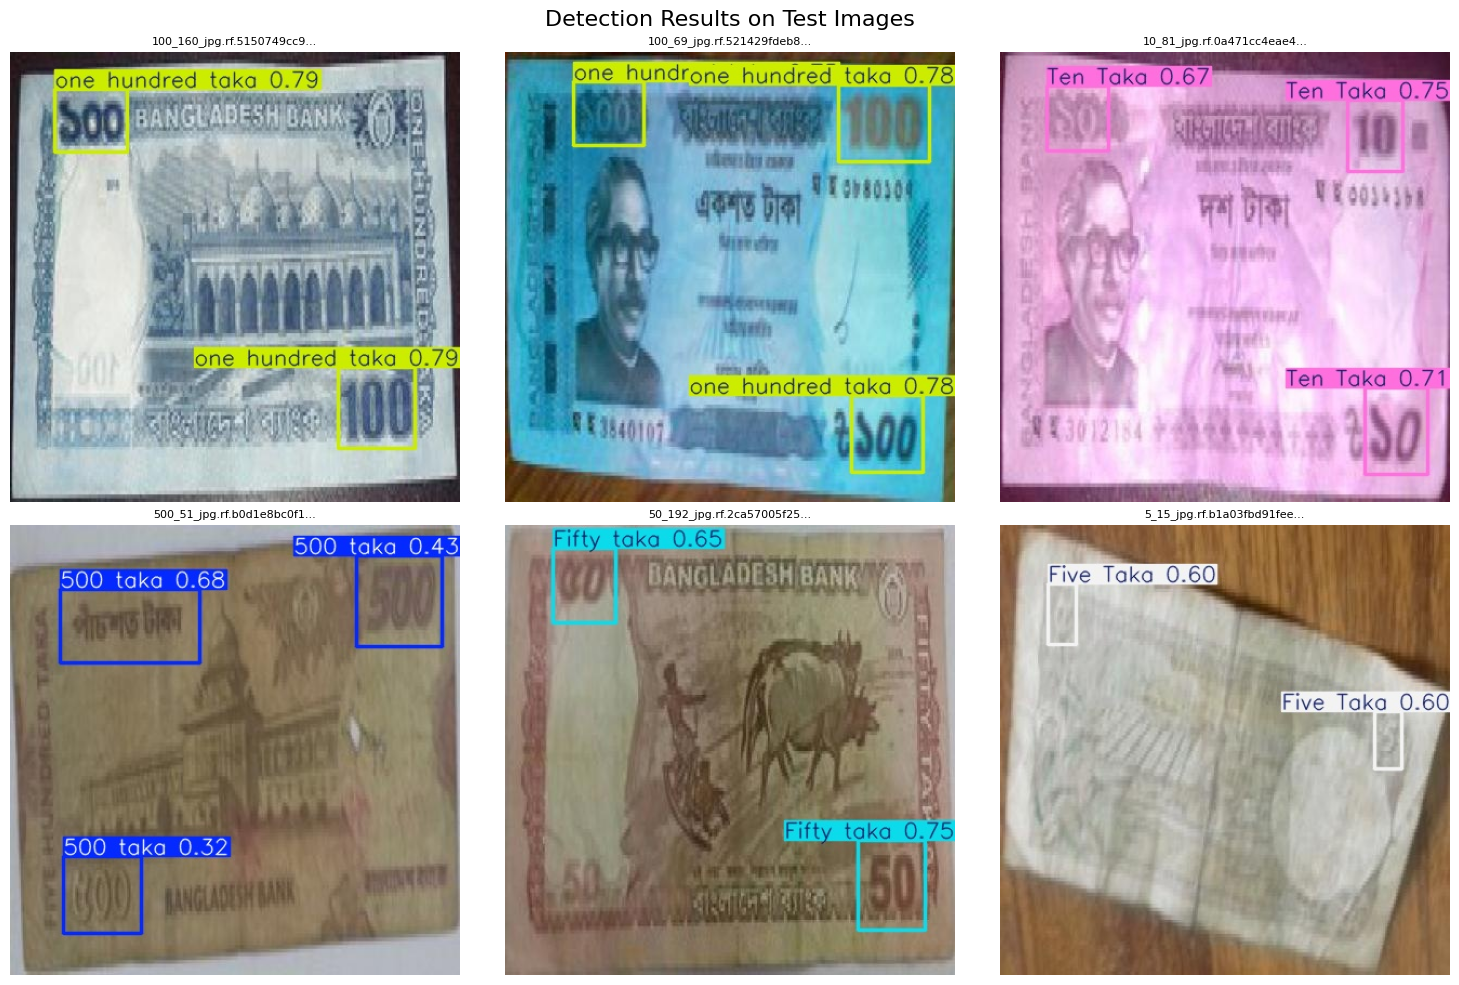

In [28]:
# Display inference results
predictions_dir = os.path.join(inference_output_dir, "predictions")

if os.path.exists(predictions_dir):
    pred_images = [f for f in os.listdir(predictions_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    if pred_images:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Detection Results on Test Images', fontsize=16)
        
        for ax, img_name in zip(axes.flatten(), pred_images[:6]):
            img_path = os.path.join(predictions_dir, img_name)
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(img_name[:25] + '...', fontsize=8)
        
        plt.tight_layout()
        plt.show()
else:
    print("No prediction images found.")

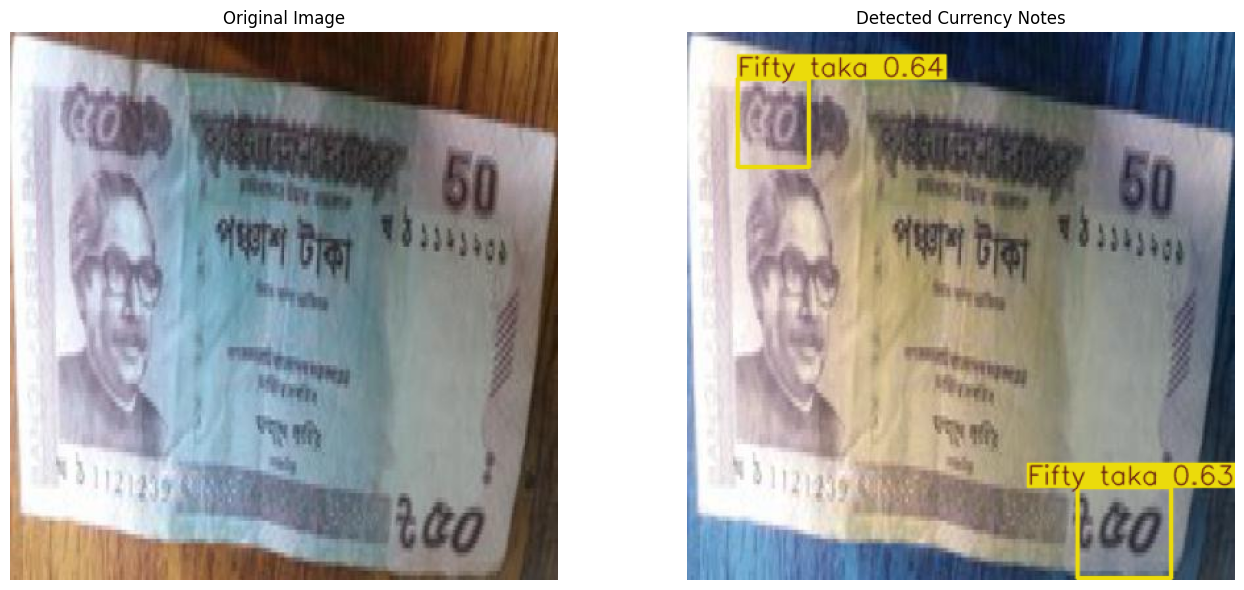


📋 Detection Details:
Detection 1:
  Class: Fifty taka
  Confidence: 64.39%
  Bounding Box: [38.4, 35.4, 92.9, 102.6]

Detection 2:
  Class: Fifty taka
  Confidence: 63.15%
  Bounding Box: [296.3, 345.9, 367.9, 414.7]



In [29]:
# Show detailed detection on a single image
def show_detailed_detection(image_path):
    """Display detection with detailed bounding box information"""
    
    # Run prediction
    results = trained_model.predict(source=image_path, conf=0.25, verbose=False)
    
    # Get the result
    result = results[0]
    
    # Plot with annotations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Original image
    original_img = Image.open(image_path)
    ax1.imshow(original_img)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Annotated image
    annotated_img = result.plot()
    ax2.imshow(annotated_img)
    ax2.set_title('Detected Currency Notes')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detection details
    print("\n📋 Detection Details:")
    print("="*50)
    
    if len(result.boxes) > 0:
        for i, box in enumerate(result.boxes):
            class_id = int(box.cls[0])
            class_name = filtered_class_names[class_id]  # Use filtered class names
            confidence = float(box.conf[0])
            coords = box.xyxy[0].cpu().numpy()
            
            print(f"Detection {i+1}:")
            print(f"  Class: {class_name}")
            print(f"  Confidence: {confidence:.2%}")
            print(f"  Bounding Box: [{coords[0]:.1f}, {coords[1]:.1f}, {coords[2]:.1f}, {coords[3]:.1f}]")
            print()
    else:
        print("No detections found.")

# Show detailed detection on a random test image
test_images_dir_filtered = os.path.join(FILTERED_DATA_DIR, "test", "images")
test_images_filtered = [f for f in os.listdir(test_images_dir_filtered) if f.endswith(('.jpg', '.jpeg', '.png'))]
random_test_image = os.path.join(test_images_dir_filtered, random.choice(test_images_filtered))
show_detailed_detection(random_test_image)

---
## 5. Results & Submission (10 Marks)

### Summary

#### Dataset
- **Source**: Roboflow Universe - Bangladeshi Currency Detection
- **Original Dataset**: ~1,770 images with 11 classes
- **Filtered Dataset**: Excluded 2 underrepresented classes
  - **Excluded**: "Five Hundred taka" (1 sample), "currency" (71 samples)
  - **Final Classes**: 9 well-represented Bangladeshi Taka denominations
- **Split**: Train (~80%), Validation (~10%), Test (~10%)

#### Model
- **Architecture**: YOLOv12 (or YOLO11 if v12 not available)
- **Variant**: Nano (n) for efficiency
- **Framework**: Ultralytics
- **Classes**: 9 (after filtering)

#### Training
- **Epochs**: 50
- **Batch Size**: 8
- **Image Size**: 640×640
- **Device**: GPU (CUDA)

#### Data Preprocessing
- Filtered out classes with insufficient samples
- Remapped class IDs for remaining 9 classes
- Maintained YOLO annotation format

### Deliverables
1. ✅ Trained model weights (`best.pt`, `last.pt`)
2. ✅ Training logs and metrics
3. ✅ Sample inference images with bounding boxes
4. ✅ Filtered dataset structure and annotation files
5. ✅ Training and evaluation scripts (this notebook)

In [30]:
# Final Summary
print("\n" + "="*60)
print("📊 FINAL PROJECT SUMMARY")
print("="*60)

print("\n📁 Dataset Information:")
print(f"   - Original Dataset: {total_count} images (11 classes)")
print(f"   - Filtered Dataset: {sum(s['kept'] for s in splits_stats.values())} images ({len(filtered_class_names)} classes)")
print(f"   - Training: {splits_stats['train']['kept']} | Validation: {splits_stats['valid']['kept']} | Test: {splits_stats['test']['kept']}")
print(f"   - Excluded Classes: {CLASSES_TO_EXCLUDE}")

print("\n🎯 Model Configuration:")
print(f"   - Architecture: YOLO (v12/v11)")
print(f"   - Number of Classes: {len(filtered_class_names)}")
print(f"   - Classes: {filtered_class_names}")
print(f"   - Epochs: {EPOCHS}")
print(f"   - Batch Size: {BATCH_SIZE}")
print(f"   - Image Size: {IMG_SIZE}x{IMG_SIZE}")

print("\n📈 Saved Artifacts:")
print(f"   - Best Weights: {best_model_path}")
print(f"   - Training Results: {results_dir}")
print(f"   - Inference Results: {inference_output_dir}")
print(f"   - Filtered Dataset: {FILTERED_DATA_DIR}")

print("\n✅ Project Complete!")
print("="*60)


📊 FINAL PROJECT SUMMARY

📁 Dataset Information:
   - Original Dataset: 1523 images (11 classes)
   - Filtered Dataset: 1523 images (9 classes)
   - Training: 1166 | Validation: 168 | Test: 189
   - Excluded Classes: ['Five Hundred taka', 'currency']

🎯 Model Configuration:
   - Architecture: YOLO (v12/v11)
   - Number of Classes: 9
   - Classes: ['500 taka', 'Fifty taka', 'Five Taka', 'One Taka', 'One Thousand taka', 'Ten Taka', 'Twenty', 'one hundred taka', 'two taka']
   - Epochs: 50
   - Batch Size: 8
   - Image Size: 640x640

📈 Saved Artifacts:
   - Best Weights: d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\runs/detect\bd_taka_detector\weights\best.pt
   - Training Results: d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\runs/detect\bd_taka_detector
   - Inference Results: d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\inference_results
   - Filtered Dataset: d:\Study\Ostad\11. Model Finetuning & Intro to Tra

In [31]:
# Export model for deployment (optional)
print("\n📦 Exporting Model...")

# Export to ONNX format for deployment
try:
    trained_model.export(format='onnx', imgsz=IMG_SIZE)
    print("✅ Model exported to ONNX format")
except Exception as e:
    print(f"⚠️ Export failed: {e}")


📦 Exporting Model...
Ultralytics 8.3.243  Python-3.13.11 torch-2.9.1+cu130 CPU (AMD Ryzen 5 5600 6-Core Processor)

PyTorch: starting from 'd:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\runs\detect\bd_taka_detector\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 13, 8400) (38.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<2.0.0', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   - -------------------------------------- 0.5/16.5 MB 5.5 MB/s eta 0:00:03
   ------------------- -------------------- 7.9/16.5 MB 26.4 MB/s eta 0:00:01
   ---------------------------------------- 16.5/16.5 MB 37.3 MB/s  0:00:00
   ---------------------------------------- 0.0/244.5 MB ? eta -:--:--
    --------------------------------------- 4.2/244.5 MB 33.5 MB/s eta 0:00:08
   - -------------------------------------- 9.4/244.5 MB 27.9 MB/s eta

d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\venv\Lib\site-packages\torch\onnx\_internal\torchscript_exporter\utils.py:1447: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(


ONNX: slimming with onnxslim 0.1.80...
ONNX: export success  87.0s, saved as 'd:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\runs\detect\bd_taka_detector\weights\best.onnx' (77.1 MB)

Export complete (87.9s)
Results saved to D:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\runs\detect\bd_taka_detector\weights
Predict:         yolo predict task=detect model=d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\runs\detect\bd_taka_detector\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\runs\detect\bd_taka_detector\weights\best.onnx imgsz=640 data=d:\Study\Ostad\11. Model Finetuning & Intro to Transformers\Assignment\data_filtered\data.yaml  
Visualize:       https://netron.app
✅ Model exported to ONNX format
